# Imports

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import squidpy as sq

import cell2location
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel, Cell2location
from matplotlib import rcParams

/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categoric

# Load data

In [3]:
adata_st = sc.read('../../lucas_data/Visium_Mouse_Brain_SPAPROS_filtered_celltypes_annotated.h5ad')
adata_sc = sc.read('../../lucas_data/SC_REF_for_VISIUM_preprocessed.h5ad')

In [4]:
#RESULT FOLDER
results_folder = '../results'
ref_run_name = f'{results_folder}/reference_signatures_lucas_data'
run_name = f'{results_folder}/cell2location_map_lucas_data'

In [7]:
adata_st

View of AnnData object with n_obs × n_vars = 2695 × 788
    obs: 'X', 'Y', 'cell_type', 'Cell_type', 'Cell_Type'
    var: 'gene_id', 'p_val', 'q_val', 'SYMBOL', 'MT_gene'
    uns: 'X_name', 'centroids'
    obsm: 'cell_type_distribution', 'cell_type_distributions', 'spatial', 'MT'

# Setup for cell2location

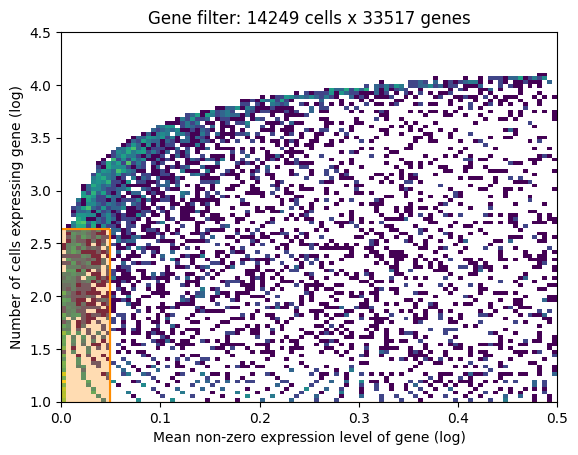

In [6]:
# Clean up gene names in spatial data
adata_st.var['SYMBOL'] = adata_st.var_names
#adata_st.var.set_index('gene_ids', drop=True, inplace=True)
adata_st.var['MT_gene'] = [gene.startswith('mt-') for gene in adata_st.var['SYMBOL']]
adata_st.obsm['MT'] = adata_st[:, adata_st.var['MT_gene'].values].X.toarray()
adata_st = adata_st[:, ~adata_st.var['MT_gene'].values]

# Clean up gene names in sc data
adata_sc.var['SYMBOL'] = adata_sc.var.index

# Filter lowly expressed genes in single-cell data
selected = filter_genes(adata_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_sc = adata_sc[:, selected].copy()


In [12]:
# Set up for regression model
RegressionModel.setup_anndata(adata=adata_sc, labels_key='cell_type')

# Create and train regression model
mod = RegressionModel(adata_sc)
mod.view_anndata_setup()
mod.train(max_epochs=500)

# Plot training history
mod.plot_history(0)
plt.legend(labels=['full data training'])


Anndata setup with scvi-tools version 1.3.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 14249 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  23   │
│          n_vars          │ 33517 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                    labels State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │   Astro    │          0          │
│                        │     CR     │          1          │
│                        │    Endo    │          2          │
│                        │  L2/3 IT   │          3          │
│                        │     L4     │          4          │
│                        │   L5 IT    │          5          │
│                        │   L5 PT    │          6          │
│                        │   L6 CT    │          7          │
│                        │   L6 IT    │          8          │
│                        │    L6b     │          9          │
│                        │   Lamp5    │         10          │
│                        │ Macrophage │         11          │
│                        │   Meis2    │         12          │
│                        │     NP     │         13          │
│                        │   Oligo    │         14          │
│                        │    Peri    │         15          │
│                        │   Pvalb    │         16          │
│                        │    SMC     │         17          │
│                        │  Serpinf1  │         18          │
│                        │    Sncg    │         19          │
│                        │    Sst     │         20          │
│                        │    VLMC    │         21          │
│                        │    Vip     │         22          │
└────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 3/500:   0%| | 2/500 [00:39<2:43:34, 19.71s/it, v_num=1, elbo_train=1.98e+


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [6]:
# Export reference signatures
adata_sc = mod.export_posterior(
    adata_sc, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)
adata_sc.write(f'{ref_run_name}/sc_lucas_data.h5ad')
mod.save(f'{ref_run_name}', overwrite=True)


Sampling global variables, sample: 100%|███████████████████████████| 999/999 [01:20<00:00, 12.46it/s]


In [7]:
# Get shared genes

#NO SHARED GENES BETWEEN SC AND ST
shared_genes = adata_st.var_names.intersection(adata_sc.varm['means_per_cluster_mu_fg'].index)

# Subset and align both AnnData objects to shared genes
adata_st = adata_st[:, shared_genes].copy()
cell_state_df = adata_sc.varm['means_per_cluster_mu_fg'].loc[shared_genes]

# Prepare spatial data for cell2location model
Cell2location.setup_anndata(adata_st)

# Run Cell2location model using reference signatures
c2l_model = Cell2location(
    adata_st,
    cell_state_df=cell_state_df,
    N_cells_per_location=30,
    detection_alpha=0.5,
    detection_mean=10
)
c2l_model.train(max_epochs=30000)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 263/30000:   1%|              | 262/30000 [00:27<50:27,  9.82it/s, v_num=1, elbo_train=9.88e+5]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
# Export cell abundance estimates (posterior)
adata_st = c2l_model.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': adata_st.n_obs}
)

# Save model and results
c2l_model.save(f"{run_name}", overwrite=True)
adata_st.write(f"{run_name}/sp.h5ad")

print("Pipeline complete. Results saved to:", run_name)

In [ ]:
adata_sc = mod.export_posterior(
    adata_sc, use_quantiles=True,
    # choose quantiles
    add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 10}
)

In [ ]:
#load model and output
#adata_file = f"{run_name}/sp.h5ad"
#adata_vis = sc.read_h5ad(adata_file)
#mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)